In [36]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import json

# These commands below set some options for pandas and to have matplotlib show the charts in the notebook
pd.set_option('display.max_rows', 1000)
pd.options.display.float_format = '{:,.10f}'.format
%matplotlib inline

# Load the data
# We have this defaulted to the folder OUTSIDE of your repo - please change it as needed
population = pd.read_csv('Population by Age and Sex - US, States, Counties.csv')

def load_json(file_name: str):
    with open(file_name, 'r') as file:
        file_data = json.load(file)
    rows = []
    for person in file_data:
        base_info = {
            "bioguide_id": person["id"].get("bioguide"),
            "govtrack_id": person["id"].get("govtrack"),
            "icpsr_id": person["id"].get("icpsr"),
            "wikipedia": person["id"].get("wikipedia"),
            "wikidata": person["id"].get("wikidata"),
            "first_name": person["name"]["first"],
            "last_name": person["name"]["last"],
            "gender": person["bio"].get("gender"),
            "birthday": person["bio"].get("birthday"),
        }
        for term in person["terms"]:
            row = base_info.copy()
            row.update({
                "type": term["type"],
                "start": term["start"],
                "end": term["end"],
                "state": term["state"],
                "district": term.get("district"),
                "party": term.get("party"),
                "class": term.get("class"),
            })
            rows.append(row)

    # Convert to DataFrame
    legislators = pd.DataFrame(rows)
    return legislators

# load both historical & current into dataframes
incumbent = load_json('legislators-current.json')
non_incumbent = load_json('legislators-historical.json')

# filter historical from people born after 1900
non_incumbent['birthday'] = pd.to_datetime(non_incumbent['birthday'])
non_incumbent = non_incumbent[non_incumbent['birthday'].dt.year >= 1900] 

# check shape before
#print(incumbent.shape)
#print(non_incumbent.shape)

# merged dataframe: all legislators incumbent & non_incumbent 
all_legislators = pd.concat([incumbent, non_incumbent], ignore_index=True)

#check shape after
#print(all_legislators.columns)

# get earliest term start & latest term end and put in dataframe with bioguide as key
earliest_to_latest_terms = all_legislators.groupby('bioguide_id').agg(
    Earliest_Start_Date=('start', 'min'),
    Latest_End_Date=('end', 'max')
).reset_index()

# drop duplicates & term start/end now that we have the earliest term start & latest term end
all_legislators = all_legislators.drop_duplicates(subset='bioguide_id')
all_legislators['bioguide_id'].value_counts()
all_legislators = all_legislators.drop(['start', 'end'], axis=1)

# 
legislators_with_allterms = pd.merge(earliest_to_latest_terms, all_legislators, on='bioguide_id', how='left')
#print("\nInner Join:")
legislators_with_allterms.head()
#test = merged_inner[merged_inner['last_name'] == 'Sanders']
#test

# Convert dates to datetime
legislators_with_allterms['Earliest_Start_Date'] = pd.to_datetime(legislators_with_allterms['Earliest_Start_Date'])
legislators_with_allterms['Latest_End_Date'] = pd.to_datetime(legislators_with_allterms['Latest_End_Date'])

# Extract years from Start_Date and End_Date & filter End date to >= 2000
# legislators_with_allterms['Year_Start'] = legislators_with_allterms['Earliest_Start_Date'].dt.year
# legislators_with_allterms['Year_End'] = legislators_with_allterms['Latest_End_Date'].dt.year
legislators_with_allterms = legislators_with_allterms[legislators_with_allterms['Latest_End_Date'].dt.year >= 2000] 

print(legislators_with_allterms.head())

total_houserep = 435
total_senate = 100


   bioguide_id Earliest_Start_Date Latest_End_Date  govtrack_id  \
3      A000014          1985-01-03      2010-03-01       400001   
7      A000022          1983-01-03      2013-01-03       400003   
12     A000055          1997-01-07      2025-01-03       400004   
13     A000069          1977-01-04      2013-01-03       300001   
21     A000109          1991-01-03      2009-01-03       300003   

            icpsr_id         wikipedia wikidata first_name    last_name  \
3  15,245.0000000000  Neil Abercrombie  Q469689       Neil  Abercrombie   
7  15,000.0000000000     Gary Ackerman  Q972029       Gary     Ackerman   
12 29,701.0000000000   Robert Aderholt  Q672671     Robert     Aderholt   
13 14,400.0000000000      Daniel Akaka  Q359366     Daniel        Akaka   
21 29,108.0000000000      Wayne Allard  Q724250      Wayne       Allard   

   gender             birthday type state     district       party  class  
3       M  1938-06-26 00:00:00  rep    HI 1.0000000000    Democrat    

In [37]:
# Congress members with birthyear from 1900
non_incumbent['birthday'] = pd.to_datetime(non_incumbent['birthday'])
non_incumbent = non_incumbent[non_incumbent['birthday'].dt.year >= 1900]

incumbent['birthday'] = pd.to_datetime(incumbent['birthday'])
# incumbent = incumbent[incumbent['birthday'].dt.year >= 1900]

# Convert terms start and end to datetime
incumbent['start'] = pd.to_datetime(incumbent['start'])
incumbent['end'] = pd.to_datetime(incumbent['end'])
non_incumbent['start'] = pd.to_datetime(non_incumbent['start'])
non_incumbent['end'] = pd.to_datetime(non_incumbent['end'])

# Descrtiptive Analysis - How can I summarize these data?
# There are duplicates here as each candidate can have multiple entries
def group_party(df):
    party_count = df.groupby(['party']).agg(
        party_count=('party', 'count'),
    ).reset_index()
    return party_count


def group_chamber(df):
    chamber_count = df.groupby(['chamber']).agg(
        chamber_count=('chamber', 'count'),
    ).reset_index()
    return chamber_count

# incumbent_party = group_party(incumbent)
# non_incumbent_party = group_party(non_incumbent)
# print(incumbent_party)
# print(non_incumbent_party)

# Need to figure out age from birthday to end_terms since non_incumbents will be way dead
def group_age(df):
    df['age'] = df['birthday'].apply(
        lambda x: min((datetime.now() - pd.to_datetime(x)).days // 365, 100))

    # Group by party and calculate age statistics
    age_summary = df.groupby(['party', 'type', 'gender']).agg(
        average_age=('age', 'mean'),
        min_age=('age', 'min'),
        max_age=('age', 'max'),
    ).reset_index()
    # Format average_age to 2 decimal points without trailing zeros
    age_summary['average_age'] = age_summary['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    return age_summary
# inc_age = group_age(incumbent)
# noninc_age = group_age(non_incumbent)
# print(f'Incumbent:\n {inc_age}')
# print(f'Non-incumbent:\n {noninc_age}')
    
def group_gender(df):
    gender_count = df.groupby(['party', 'gender']).agg(
        count=('gender', 'count')
    ).reset_index()
    return gender_count
# incumbent_gender = group_gender(incumbent)
# non_incumbent_gender = group_gender(non_incumbent)
# print(incumbent_gender)
# print(non_incumbent_gender)

def group_years_of_service(df):
    df['years_of_service'] = (pd.to_datetime(
        df['end']) - pd.to_datetime(df['start'])).dt.days // 365

    # Group by party and calculate years of service statistics
    service_summary = df.groupby('party').agg(
        total_years=('years_of_service', 'sum'),
        average_years=('years_of_service', 'mean'),
        min_years=('years_of_service', 'min'),
        max_years=('years_of_service', 'max'),
    ).reset_index()
    return service_summary
# inc_years = group_years_of_service(incumbent)
# noninc_years = group_years_of_service(non_incumbent)
# print(noninc_years)

# Bioguide is duplicates since one candidate can serve multiple terms
def group_state_party(df):
    state_party_count = df.groupby(['state', 'party', 'type']).agg(
        legislator_count=('bioguide_id', 'count')
    ).reset_index()

    return state_party_count

# inc_sp = group_state_party(incumbent)
# print(inc_sp)

def group_dates(df):
    date_summary = df.groupby('party').agg(
        average_start=('start', lambda x: pd.to_datetime(x).mean()),
        median_start=('start', lambda x: pd.to_datetime(x).median()),
        average_end=('end', lambda x: pd.to_datetime(x).mean()),
        median_end=('end', lambda x: pd.to_datetime(x).median()),
    ).reset_index()
    return date_summary
# inc_dates = group_dates(incumbent)

def group_decade(df):
    # Add a "start_decade" column
    df['start_decade'] = pd.to_datetime(df['start']).dt.year // 10 * 10

    # Group by decade and party
    decade_summary = incumbent.groupby(['start_decade', 'party']).agg(
        legislator_count=('bioguide_id', 'count')
    ).reset_index()

    return decade_summary

# inc_decade = group_decade(incumbent)
# inc_decade

def group_top_states(df):
    top_states = df.groupby(['state', 'party', 'type']).agg(
        legislator_count=('bioguide_id', 'count')
    ).reset_index()
    # Sort and find the top states for each party
    top_states = top_states.sort_values(
        ['party', 'legislator_count'], ascending=[True, False])
    return top_states

# inc_top_states = group_top_states(incumbent)
# inc_top_states
# print(incumbent.info())

# When did they get there?
def group_age_start(df):
    # Calculate age at term start
    df['age_at_start'] = df.apply(
    lambda row: (row['start'] - row['birthday']).days // 365, axis=1)

    # Group by start date and calculate average age
    avg_age_by_term = incumbent.groupby('start').agg(
        average_age=('age_at_start', 'mean')
    ).reset_index()
    
    avg_age_by_term['average_age'] = avg_age_by_term['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )

    return avg_age_by_term

# inc_avg_start = group_age_start(incumbent)
# inc_avg_start

def age_by_party(df):
    age_summary = df.groupby('party').agg(
        count=('party', 'count'),
        average_age=('age', 'mean'),
        median_age=('age', 'median'),
        mode_age=('age', lambda x: x.mode(
        ).iloc[0] if not x.mode().empty else None),
        min_age=('age', 'min'),
        max_age=('age', 'max'),
    ).reset_index()
    age_summary['average_age'] = age_summary['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    age_summary['median_age'] = age_summary['median_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    
    return age_summary


def age_by_chamber(df):
    age_summary = df.groupby('chamber').agg(
        count=('party', 'count'),
        average_age=('age', 'mean'),
        median_age=('age', 'median'),
        mode_age=('age', lambda x: x.mode(
        ).iloc[0] if not x.mode().empty else None),
        min_age=('age', 'min'),
        max_age=('age', 'max'),
    ).reset_index()
    age_summary['average_age'] = age_summary['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    age_summary['median_age'] = age_summary['median_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )

    return age_summary


def age_by_gender(df):
    age_summary = df.groupby('gender').agg(
        count=('party', 'count'),
        average_age=('age', 'mean'),
        median_age=('age', 'median'),
        mode_age=('age', lambda x: x.mode(
        ).iloc[0] if not x.mode().empty else None),
        min_age=('age', 'min'),
        max_age=('age', 'max'),
    ).reset_index()
    age_summary['average_age'] = age_summary['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    age_summary['median_age'] = age_summary['median_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )

    return age_summary


def age_by_all(df):
    age_summary = df.groupby(['party', 'chamber', 'gender']).agg(
        count=('party', 'count'),
        average_age=('age', 'mean'),
        median_age=('age', 'median'),
        mode_age=('age', lambda x: x.mode(
        ).iloc[0] if not x.mode().empty else None),
        min_age=('age', 'min'),
        max_age=('age', 'max'),
    ).reset_index()
    age_summary['average_age'] = age_summary['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    age_summary['median_age'] = age_summary['median_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )

    return age_summary


def gender_by_party(df):
    # Group by party and gender, then count
    gender_party_counts = df.groupby(
        ['party', 'gender']).size().reset_index(name='count')

    # Calculate total counts for each party
    total_by_party = gender_party_counts.groupby(
        'party')['count'].transform('sum')

    # Add a proportion column
    gender_party_counts['proportion'] = gender_party_counts['count'] / \
        total_by_party

    return gender_party_counts

def gender_by_chamber(df):
    # Group by chamber and gender, then count
    gender_chamber_counts = df.groupby(['chamber', 'gender']).size().reset_index(name='count')

    # Calculate total counts for each chamber
    total_by_chamber = gender_chamber_counts.groupby('chamber')['count'].transform('sum')

    # Add a proportion column
    gender_chamber_counts['proportion'] = gender_chamber_counts['count'] / total_by_chamber

    return gender_chamber_counts
    

In [38]:
"""
    Descriptive Analysis:
"""
# incumbent.shape # 2721 rows
# CONGRESS AGE AND GENDER STATS
incumbent = incumbent.rename(columns={'type': 'chamber'})
incumbent['chamber'] = incumbent['chamber'].replace(
    {'rep': 'House'})
incumbent['chamber'] = incumbent['chamber'].replace(
    {'sen': 'Senate'})
grouped_incumbent = incumbent.groupby('bioguide_id').first().reset_index()
# Incumbent without grouping by bioguide_id have duplicated candidates due to multiple terms
print(grouped_incumbent.shape) # 539 rows which makes sense for combined House + Senate

# Party Affil Stats - Dems/Repubs
incumbent_party = group_party(grouped_incumbent)
print(incumbent_party)

# Chamber Stats - House(rep)/Senate(sen)
incumbent_chamber = group_chamber(grouped_incumbent)
print(incumbent_chamber)

# State Stats - House(rep)/Senate(sen)
# incumbent_state = group_top_states(grouped_incumbent)
# print(incumbent_state)

# Add Age column = current date - their birthday
def add_age(df):
    df['age'] = df['birthday'].apply(
        lambda x: min((datetime.now() - pd.to_datetime(x)).days // 365, 100))

add_age(grouped_incumbent)
grouped_incumbent.shape

# Age Stats by Party
inc_age_party = age_by_party(grouped_incumbent)
print(inc_age_party)

# Age Stats by Chamber
inc_age_chamber = age_by_chamber(grouped_incumbent)
print(inc_age_chamber)

# Age Stats By Gender
inc_age_gender = age_by_gender(grouped_incumbent)
print(inc_age_gender)

# Age Stats By All
inc_age_all = age_by_all(grouped_incumbent)
print(inc_age_all)

# Gender by Party
inc_gender_party = gender_by_party(grouped_incumbent)
print(inc_gender_party)

# Gender by Chamber
inc_gender_chamber = gender_by_chamber(grouped_incumbent)
print(inc_gender_chamber)

inc_age_gender

(539, 16)
         party  party_count
0     Democrat          265
1  Independent            2
2   Republican          272
  chamber  chamber_count
0   House            482
1  Senate             57
         party  count average_age median_age  mode_age  min_age  max_age
0     Democrat    265        60.2         60        48       27       88
1  Independent      2        81.5       81.5        80       80       83
2   Republican    272       59.12         60        60       35       91
  chamber  count average_age median_age  mode_age  min_age  max_age
0   House    482       59.29         60        48       27       91
1  Senate     57       63.53         66        60       37       82
  gender  count average_age median_age  mode_age  min_age  max_age
0      F    156       59.21         59        48       35       88
1      M    383       59.95         60        60       27       91
         party chamber gender  count average_age median_age  mode_age  \
0     Democrat   House      F    

,gender,count,average_age,median_age,mode_age,min_age,max_age
0,F,156,59.21,59,48,35,88
1,M,383,59.95,60,60,27,91


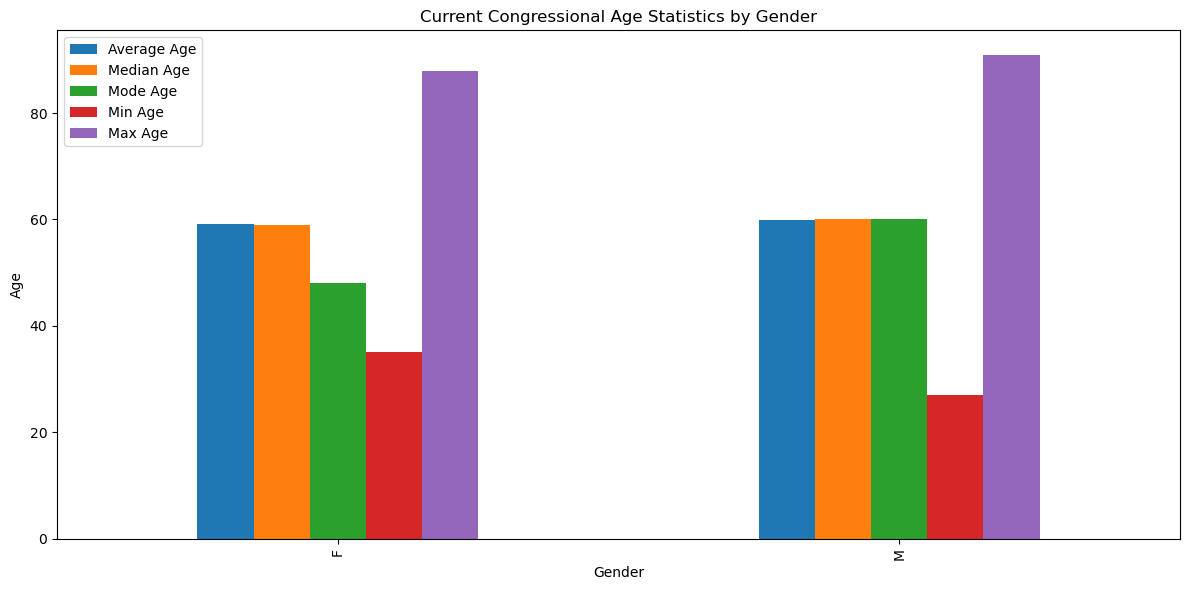

In [39]:
#age stats by party
inc_age_gender = inc_age_gender.astype({'count': 'float64','min_age': 'float64', 'average_age': 'float64', 'median_age': 'float64', 'mode_age': 'float64', 'max_age': 'float64'})
plot_age_gen = inc_age_gender.set_index('gender')
plot_age_gen[['average_age', 'median_age', 'mode_age', 'min_age', 'max_age']].plot(kind='bar', figsize=(12,6))
plt.xlabel('Gender')
plt.ylabel('Age')
plt.legend(['Average Age','Median Age', 'Mode Age', 'Min Age', 'Max Age'])
plt.title('Current Congressional Age Statistics by Gender')
plt.tight_layout()
plt.show()

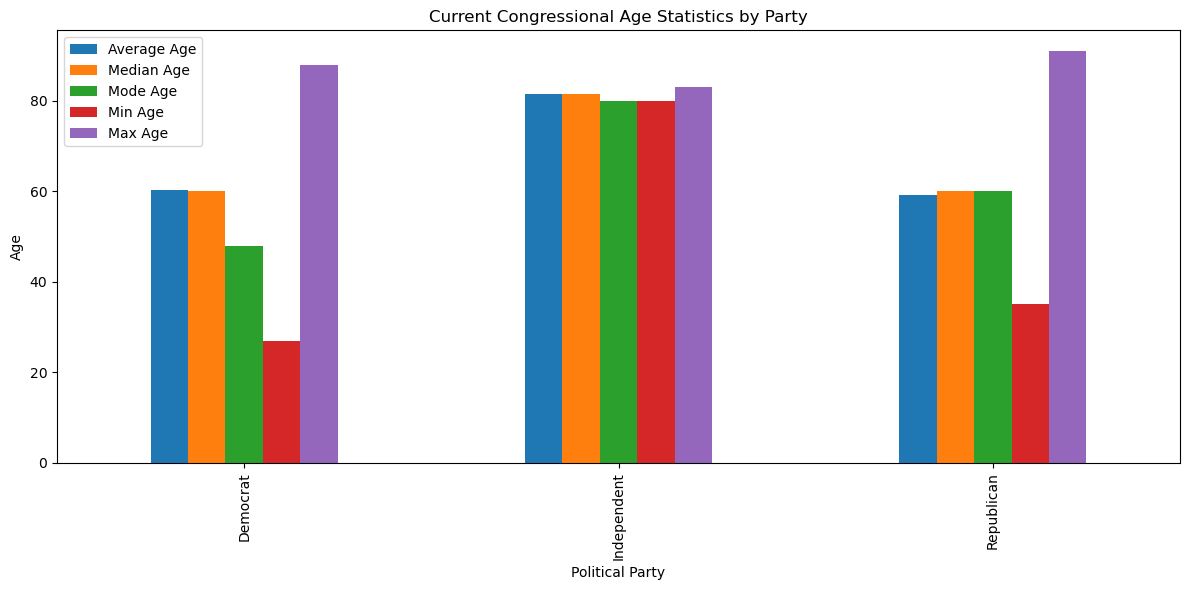

In [40]:
#age stats by party
inc_age_party = inc_age_party.astype({'min_age': 'float64', 'average_age': 'float64', 'median_age': 'float64', 'mode_age': 'float64', 'max_age': 'float64'})
plot_age_party = inc_age_party.set_index('party')
plot_age_party[['average_age', 'median_age', 'mode_age', 'min_age', 'max_age']].plot(kind='bar', figsize=(12,6)) #, 'median_age', 'mode_age'
plt.title('Age Statistics by Political Party')
plt.xlabel('Political Party')
plt.ylabel('Age')
plt.legend(['Average Age','Median Age', 'Mode Age', 'Min Age', 'Max Age'])
plt.title('Current Congressional Age Statistics by Party')
plt.tight_layout()
plt.show()


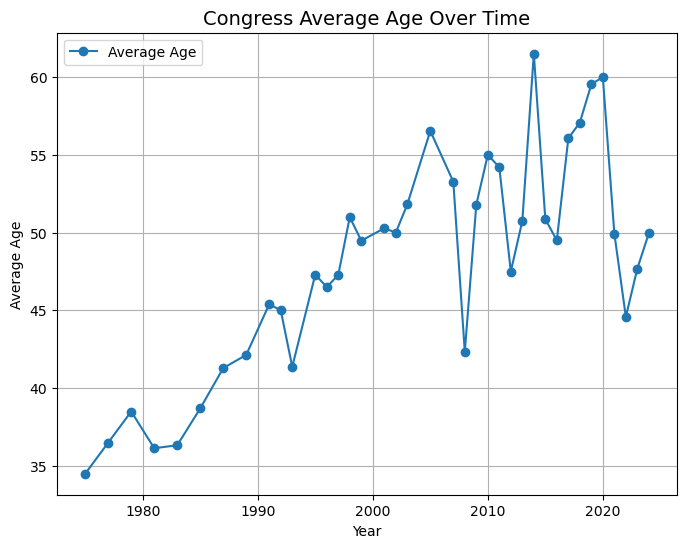

In [49]:
# CONGRESS AGE OVER TIME
# Need to use the entire incumbent dataset to track new cohorts each term
# Compare US Population Age to every new Congress term

inc_avg_over_time = group_age_start(grouped_incumbent)

inc_avg_over_time['year'] = inc_avg_over_time['start'].dt.year
inc_avg_over_time['average_age'] = pd.to_numeric(
    inc_avg_over_time['average_age'], errors='coerce')

inc_avg_by_year = inc_avg_over_time.groupby('year').agg(
    avg_age=('average_age', 'mean')
).reset_index()

# print(inc_avg_by_year)

# Create Line Plot
plt.figure(figsize=(8, 6))
plt.plot(inc_avg_by_year['year'], inc_avg_by_year['avg_age'], marker='o', label='Average Age')

# Add Labels and Title
plt.xlabel('Year')
plt.ylabel('Average Age')
plt.title('Congress Average Age Over Time', fontsize=14)
plt.legend()
plt.grid(True)

# Show Plot
plt.show()

In [42]:
##Gabby test cell
filtered_pop = population[population['Description'] == 'U.S.']

# Remove unnecessary columns
filtered_pop = filtered_pop.drop(['IBRC_Geo_ID', 'Statefips', 'Countyfips'], axis=1)

# Function to get percentages of populations
def percent(row, name):
    base = row['Total Population']
    return row[name]/base

for c in filtered_pop.columns:
    if 'population' in c.lower():
        filtered_pop['% ' + c] = filtered_pop.apply(lambda row: percent(row, c), axis = 1)
#filtered_pop['0-4 Percent'] = filtered_pop.apply(lambda row: percent(row, "Population 0-4"), axis = 1)
def get_avg_age(row):
    base = row['Total Population']
    populations = [row['Population 0-4'], row['Population 5-17'], row['Population 18-24'], row['Population 25-44'], row['Population 45-64'], row['Population 65+']]  # Populations by group
    midpoints = [2.5, 11, 21, 34.5, 54.5, 75]  # Midpoints of age groups
    weighted_ages = sum(pop * mid for pop, mid in zip(populations, midpoints))
    return weighted_ages / base
# Weighted sum of ages

filtered_pop['Average Age'] = filtered_pop.apply(lambda row: get_avg_age(row), axis = 1)
filtered_pop.head()

,Description,Year,Total Population,Population 0-4,Population 5-17,Population 18-24,Population 25-44,Population 45-64,Population 65+,Population Under 18,...,% Population 18-24,% Population 25-44,% Population 45-64,% Population 65+,% Population Under 18,% Population 18-54,% Population 55+,% Male Population,% Female Population,Average Age
0,U.S.,2000,"282,162,411.0000000000","19,178,293.0000000000","53,197,896.0000000000","27,315,274.0000000000","84,973,340.0000000000","62,428,040.0000000000","35,069,568.0000000000","72,376,189.0000000000",...,0.0968069202,0.3011504605,0.2212486056,0.1242885892,0.2565054245,0.5326279552,0.2108666204,0.4906514887,0.5093485113,36.0461526979
1,U.S.,2001,"284,968,955.0000000000","19,298,217.0000000000","53,372,958.0000000000","27,992,652.0000000000","84,523,274.0000000000","64,491,563.0000000000","35,290,291.0000000000","72,671,175.0000000000",...,0.0982305318,0.2966052004,0.2263108380,0.1238390722,0.2550143576,0.5330482192,0.2119374231,0.4909008141,0.5090991859,36.1471260404
2,U.S.,2002,"287,625,193.0000000000","19,429,192.0000000000","53,507,265.0000000000","28,480,708.0000000000","83,990,295.0000000000","66,695,526.0000000000","35,522,207.0000000000","72,936,457.0000000000",...,0.0990202134,0.2920129983,0.2318834637,0.1235017233,0.2535816012,0.5300759485,0.2163424502,0.4910229091,0.5089770909,36.2693702999
3,U.S.,2003,"290,107,933.0000000000","19,592,446.0000000000","53,508,312.0000000000","28,916,746.0000000000","83,398,001.0000000000","68,828,899.0000000000","35,863,529.0000000000","73,100,758.0000000000",...,0.0996758196,0.2874723216,0.2372527297,0.1236213317,0.2519777975,0.5278542349,0.2201679676,0.4909514039,0.5090485961,36.4105690209
4,U.S.,2004,"292,805,298.0000000000","19,785,885.0000000000","53,511,850.0000000000","29,302,179.0000000000","83,066,831.0000000000","70,935,234.0000000000","36,203,319.0000000000","73,297,735.0000000000",...,0.1000739372,0.2836930601,0.2422607599,0.1236429779,0.2503292649,0.5259431474,0.2237275877,0.4912069999,0.5087930001,36.5446449982


(1998.0, 2021.0)

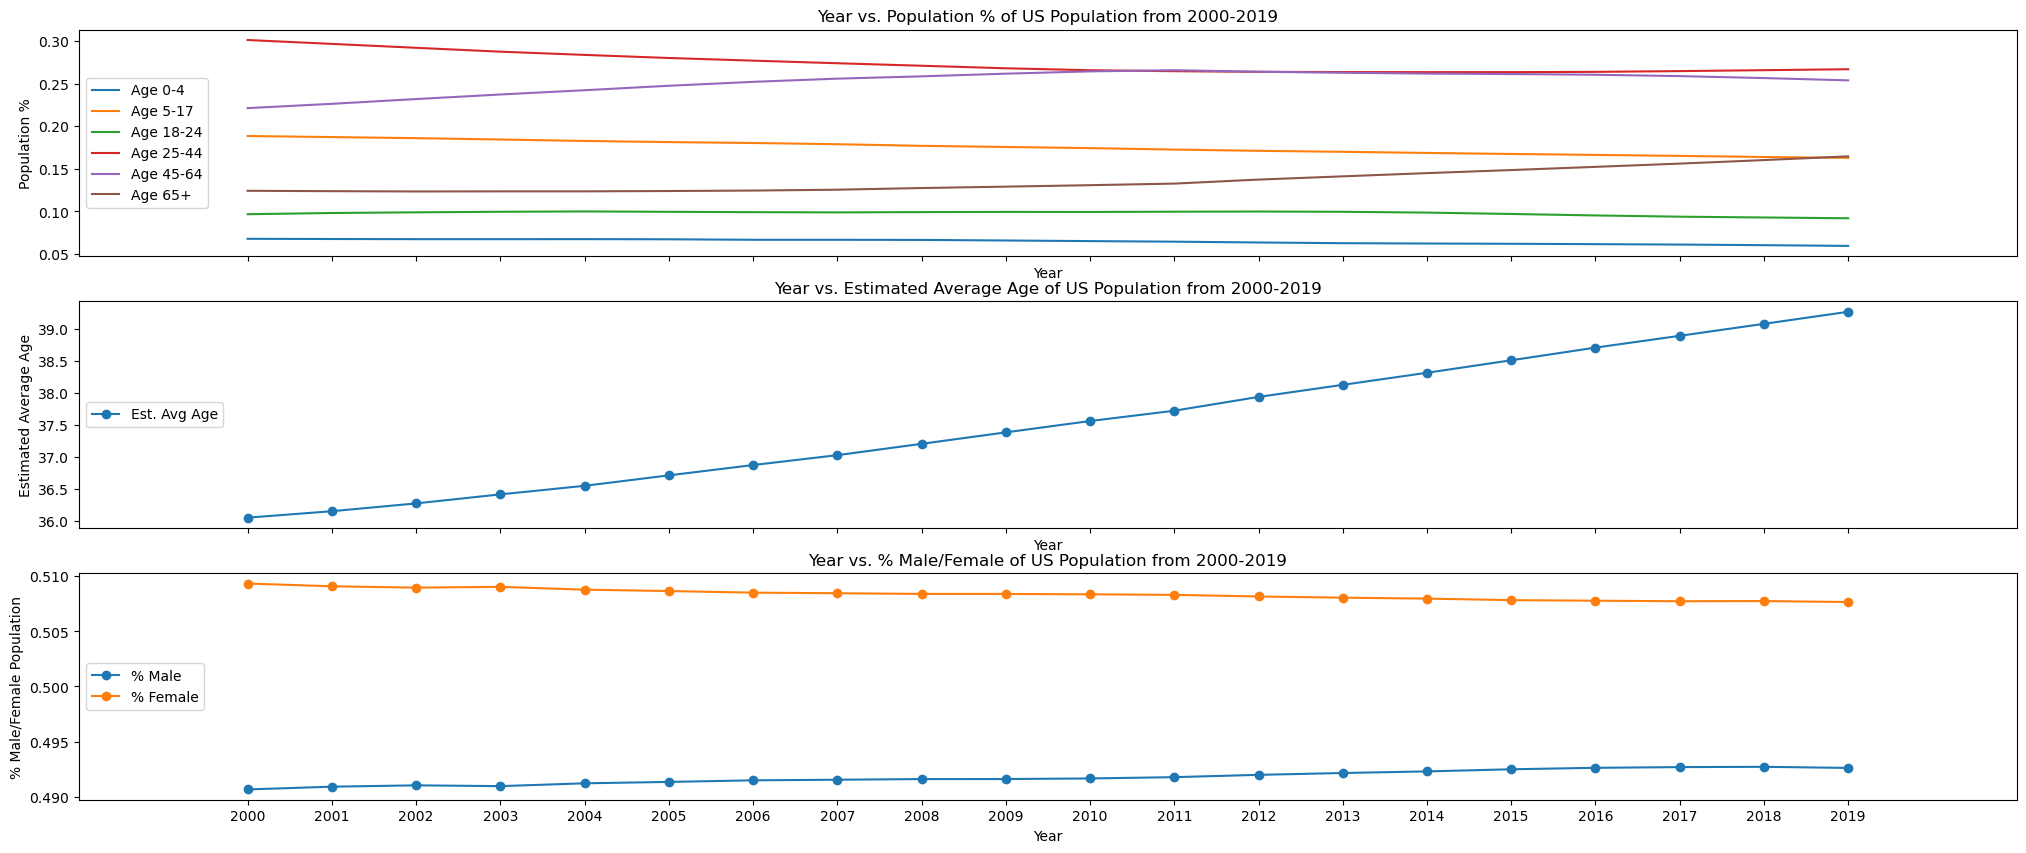

In [50]:
fig_width = len(filtered_pop)*1.25
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(fig_width,10))

ax1.plot(filtered_pop['Year'], filtered_pop['% Population 0-4'], label= 'Age 0-4')
ax1.plot(filtered_pop['Year'], filtered_pop['% Population 5-17'], label= 'Age 5-17')
ax1.plot(filtered_pop['Year'], filtered_pop['% Population 18-24'], label= 'Age 18-24')
ax1.plot(filtered_pop['Year'], filtered_pop['% Population 25-44'], label= 'Age 25-44')
ax1.plot(filtered_pop['Year'], filtered_pop['% Population 45-64'], label= 'Age 45-64')
ax1.plot(filtered_pop['Year'], filtered_pop['% Population 65+'], label= 'Age 65+')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population %')
ax1.set_title('Year vs. Population % of US Population from 2000-2019')
ax1.legend(loc='center left')

ax2.plot(filtered_pop['Year'], filtered_pop['Average Age'], label= 'Est. Avg Age', marker='o')
ax2.set_xlabel('Year')
ax2.set_ylabel('Estimated Average Age')
ax2.set_title('Year vs. Estimated Average Age of US Population from 2000-2019')
ax2.legend(loc='center left')

ax3.plot(filtered_pop['Year'], filtered_pop['% Male Population'], label= '% Male', marker='o')
ax3.plot(filtered_pop['Year'], filtered_pop['% Female Population'], label= '% Female', marker='o')
ax3.set_xlabel('Year')
ax3.set_ylabel('% Male/Female Population')
ax3.set_title('Year vs. % Male/Female of US Population from 2000-2019')
ax3.legend(loc='center left')


plt.xticks(filtered_pop['Year'])
plt.xlim(1998, 2021)

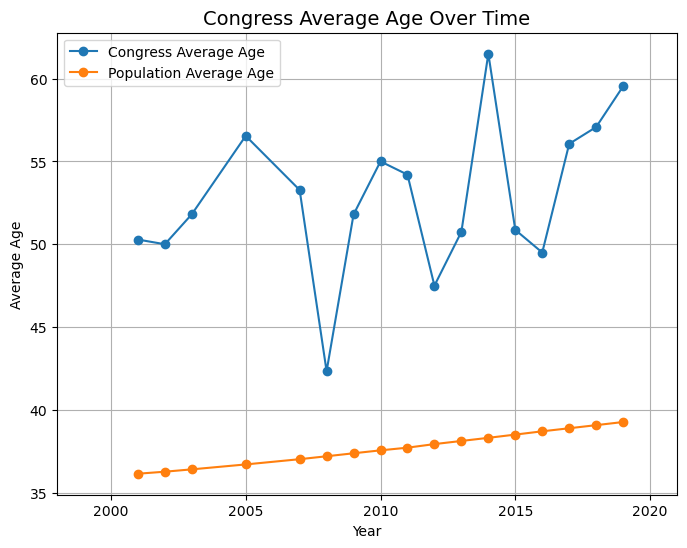

In [51]:
''' CONGRESS VS. POPULATION AGE BY YEAR '''

congress_age_by_year = group_age_start(grouped_incumbent)
congress_age_by_year['year'] = congress_age_by_year['start'].dt.year
congress_age_by_year['average_age'] = pd.to_numeric(
    congress_age_by_year['average_age'], errors='coerce')

congress_age_by_year = congress_age_by_year.groupby('year').agg(
    avg_age=('average_age', 'mean')
).reset_index()

congress_age_by_year = congress_age_by_year[congress_age_by_year['year'] >= 1999]
congress_age_by_year = congress_age_by_year[congress_age_by_year['year'] <= 2019]
combined_age_over_time = pd.merge(congress_age_by_year[['year', 'avg_age']], filtered_pop[['Year','Average Age']], left_on='year', right_on='Year')
# print(combined_age_over_time)

# inc_avg_over_time['avg_age'] = inc_avg_over_time['avg_age'].map(
#     lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
# )
# print(inc_avg_by_year['avg_age'].dtype)

# Create Line Plot
plt.figure(figsize=(8, 6))
plt.plot(combined_age_over_time['year'], combined_age_over_time['avg_age'], marker='o', label='Congress Average Age')
plt.plot(combined_age_over_time['year'], combined_age_over_time['Average Age'], marker='o', label='Population Average Age')

# Add Labels and Title
plt.xlabel('Year')
plt.ylabel('Average Age')
plt.title('Congress Average Age Over Time', fontsize=14)
plt.legend()
plt.grid(True)
# plt.xticks(inc_avg_over_time['year'])
plt.xlim(1998, 2021)

# Show Plot
plt.show()

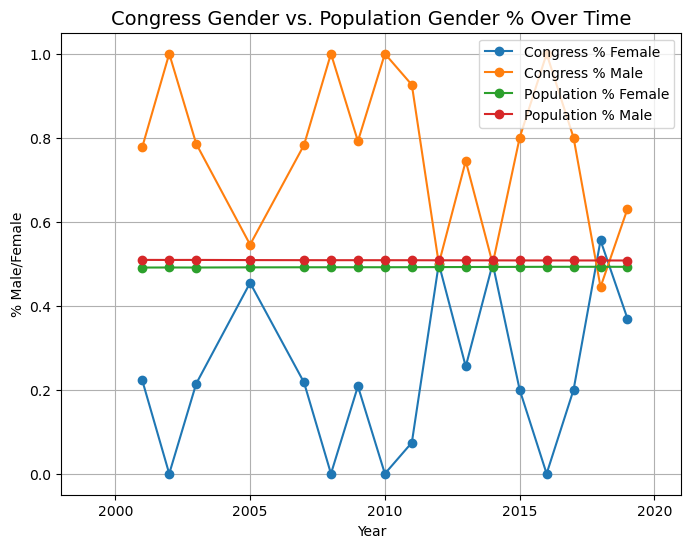

In [65]:
''' CONGRESS VS POPULATION GENDER BY YEAR '''
def group_gender_start(df):
    df['age_at_start'] = df.apply(lambda row: (row['start'] - row['birthday']).days // 365, axis=1)

    # Extract year from the start date
    df['year'] = df['start'].dt.year

    # Group by year and gender
    grouped = df.groupby(['year', 'gender']).size().reset_index(name='count')

    # Total count per year
    total_by_year = grouped.groupby('year')['count'].transform('sum')

    # Calculate percentage for each gender within a year
    grouped['percent'] = (grouped['count'] / total_by_year)

    # Pivot for male and female percentages
    pivoted = grouped.pivot(index='year', columns='gender', values='percent').fillna(0)

    # Optionally rename columns for clarity
    pivoted.columns = [f"percent_{col}" for col in pivoted.columns]

    # Reset index for final output
    pivoted = pivoted.reset_index()

    return pivoted

inc_age_gender = group_gender_start(grouped_incumbent)
inc_age_gender

inc_age_gender = inc_age_gender[inc_age_gender['year'] >= 1999]
inc_age_gender = inc_age_gender[inc_age_gender['year'] <= 2019]
combined_gender_over_time = pd.merge(inc_age_gender[['year', 'percent_F', 'percent_M']], filtered_pop[['Year','% Male Population', '% Female Population']], left_on='year', right_on='Year')

# Create Line Plot
plt.figure(figsize=(8, 6))
plt.plot(combined_gender_over_time['year'], combined_gender_over_time['percent_F'], marker='o', label='Congress % Female')
plt.plot(combined_gender_over_time['year'], combined_gender_over_time['percent_M'], marker='o', label='Congress % Male')
plt.plot(combined_gender_over_time['year'], combined_gender_over_time['% Male Population'], marker='o', label='Population % Female')
plt.plot(combined_gender_over_time['year'], combined_gender_over_time['% Female Population'], marker='o', label='Population % Male')

# Add Labels and Title
plt.xlabel('Year')
plt.ylabel('% Male/Female')
plt.title('Congress Gender vs. Population Gender % Over Time', fontsize=14)
plt.legend()
plt.grid(True)
# plt.xticks(inc_avg_over_time['year'])
plt.xlim(1998, 2021)

# Show Plot
plt.show()


In [5]:
##Chad test cell